# Sample deep-learning model for the SolarMap challenge

## The challenge

The goal of the challenge is to correctly predict the orientation of a number of rooftops, given an image taken from a satellite.

## The data
The data consists of 2 datasets:
- a collection of images of 14,104 rooftops, in various shapes and sizes
- the result of a manual tagging campaign of the rooftops, whose orientation was determined by visual inspection. Approx. 70% of the rooftops are present in this dataset, and you are asked to infer the orientation of the remaining 30%

### Images
The images are distributed in the `images.zip` file. Each entry of the archive is a file named `NNNNN.jpg`, where `NNNNN` is the ID of the rooftop between 0 and 14,103.

The images were downloaded from the MapBox satellite map.

### Tagging campaign
The results of the tagging campaign are stored in a comma-separated file, `train.csv`, containing 2 columns:
- `id`, which is the numerical ID of the rooftop. It is the same ID as in the images archive
- `orientation`, which is the orientation of the rooftop as determined by visual inspection
   - `1` = the roof appears north-south oriented
   - `2` = the roof appears west-east oriented
   - `3` = the roof appears flat
   - `4` = the orientation could be determined by visual inspection

The column names are recalled as headers in the CSV file.

# A few settings

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os.path
import re

In [3]:
DATA_DIR = os.path.expanduser('~/solarmap-data/')
IMAGE_DIR = DATA_DIR + 'images/'

# Exploration of the images

In [4]:
import glob
from PIL import Image

In [5]:
# Get the file names
image_files = glob.glob(IMAGE_DIR + '*.jpg')
N = len(image_files)
print("%d images" % N)

# Extract the image IDs from the file names. They will serve as an index later
image_ids = [int(re.sub(r'(^.*/|\.jpg)', '', fname)) for fname in image_files]

14104 images


In [6]:
# Load the raw images
images = {}

for i, fname in enumerate(image_files):
    # Get the ID of the image
    iid = image_ids[i]
    
    # Raw image
    image = Image.open(fname)
    image.load()
    images[iid] = image

## Displaying some images

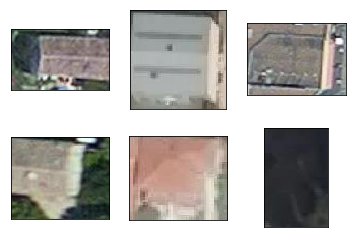

In [7]:
rows, cols = 2, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols)
samples = []
for i in range(rows * cols):
    ax = axes[int(i / cols), i % cols]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    iid = np.random.randint(0, N)
    ax.imshow(images[iid])
    samples.append(iid)

## Image sizes

(95.53949234259784, 90.12819058423142)

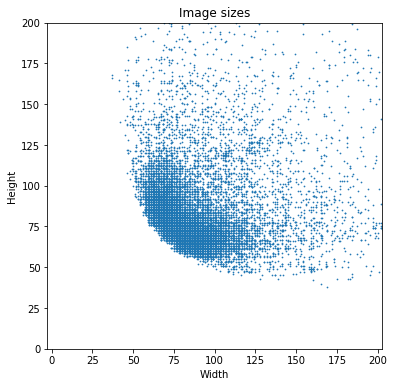

In [8]:
widths = [im.size[0] for im in images.values()]
heights = [im.size[1] for im in images.values()]

plt.figure(figsize=(6, 6))
plt.scatter(widths, heights, s=0.5)
plt.axis('equal')
plt.xlim([0,200])
plt.ylim([0,200])
plt.title('Image sizes')
plt.xlabel('Width')
plt.ylabel('Height')

# Average image size (width, height)
sum(widths) / N, sum(heights) / N

# A first model

## Load the training data

In [9]:
train_df = pd.read_csv(DATA_DIR + 'train.csv', index_col='id')
train_df.head()

,orientation
id,
2965,3
10211,1
8704,4
4450,2
10925,1


## Initialize the deep learning model

In [10]:
from keras.applications import VGG16
from keras.optimizers import SGD

Using TensorFlow backend.


In [11]:
model = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(96, 96, 3),
    pooling=None,
    )
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

## Gather the image data in a single array

In [12]:
WIDTH, HEIGHT = 96, 96

# Image data (3 channels) - will be indexed by image ID = ID of the roof
image_data = np.zeros((N, HEIGHT, WIDTH, 3))

for iid, image in images.items():
    image_data[iid, :, :, :] = np.asarray(image.resize((WIDTH, HEIGHT), resample=Image.ANTIALIAS), dtype=np.uint8)

## Compute the features by the CNN

In [13]:
# Remove mean pixel values from each channel
# These are the means from the dataset used to train the VGG16 network
image_data[:, :, :, 0] -= 103.939
image_data[:, :, :, 1] -= 116.779
image_data[:, :, :, 2] -= 123.68

In [14]:
cnn_features = model.predict(image_data)

In [15]:
cnn_features.shape

(14104, 3, 3, 512)

In [16]:
# Flatten the features computed for each roof
X = cnn_features.reshape((14104, 3 * 3 * 512))

In [17]:
X.shape

(14104, 4608)

## Prediction and validation

### Split the data set into training + test

In [18]:
# Get a 70%-30% split extract of the training data
train_ids = np.random.choice(train_df.index, size=int(.7 * len(train_df)), replace=False)
test_ids = np.array(train_df.index.difference(train_ids))

len(train_ids), len(test_ids)

(6986, 2994)

*X* (input matrix)

In [19]:
X_train, X_test = X[train_ids], X[test_ids]

*y* (output vector) and *Ym* (binarized version of *y*)

In [20]:
y_train, y_test = train_df.orientation.loc[train_ids], train_df.orientation.loc[test_ids]

In [21]:
from sklearn.preprocessing import label_binarize
classes = [1, 2, 3, 4]
Ym = pd.DataFrame(label_binarize(train_df.orientation, classes=classes), columns=classes, index=train_df.index)
Ym.head()

,1,2,3,4
id,,,,
2965,0,0,1,0
10211,1,0,0,0
8704,0,0,0,1
4450,0,1,0,0
10925,1,0,0,0


In [22]:
Ym_train, Ym_test = Ym.loc[train_ids].as_matrix(), Ym.loc[test_ids].as_matrix()

### Random forest classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf = RandomForestClassifier(class_weight='balanced')

In [25]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [26]:
y_predict = rf.predict(X_test)

In [27]:
import sklearn.metrics as metrics

In [28]:
metrics.confusion_matrix(y_test, y_predict)

array([[1121,   50,   14,   75],
       [ 278,  320,   20,   75],
       [ 141,   40,  105,   35],
       [ 401,   99,   16,  204]])

In [29]:
print(metrics.classification_report(y_test, y_predict))

             precision    recall  f1-score   support

          1       0.58      0.89      0.70      1260
          2       0.63      0.46      0.53       693
          3       0.68      0.33      0.44       321
          4       0.52      0.28      0.37       720

avg / total       0.59      0.58      0.55      2994



### Evaluate model with Average Precision metric

See http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [30]:
Ym_score = rf.predict_proba(X_test)
Ym_score

array([[ 0.1,  0.3,  0.1,  0.5],
       [ 0.2,  0.4,  0.3,  0.1],
       [ 0.7,  0.1,  0.2,  0. ],
       ..., 
       [ 0.6,  0.1,  0.1,  0.2],
       [ 0.5,  0.5,  0. ,  0. ],
       [ 0.2,  0.4,  0.1,  0.3]])

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [32]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(Ym_test[:, i], Ym_score[:, i])
    average_precision[i] = average_precision_score(Ym_test[:, i], Ym_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Ym_test.ravel(), Ym_score.ravel())
average_precision["micro"] = average_precision_score(Ym_test, Ym_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.59


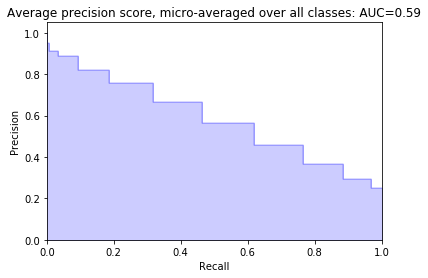

In [33]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2, where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AUC={0:0.2f}'.format(average_precision["micro"]))

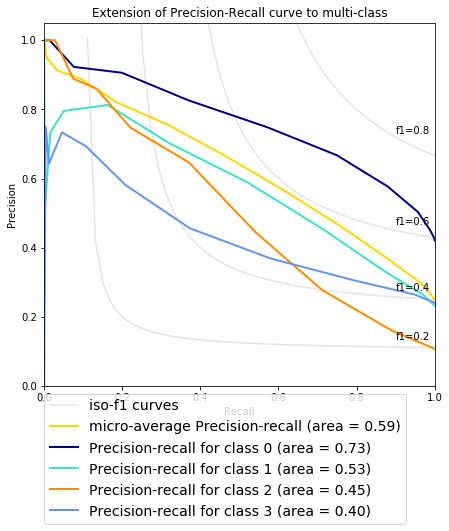

In [34]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(len(classes)), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

## Save the result

In [35]:
image_ids_for_submit = pd.Index(image_ids).difference(train_df.index)

In [36]:
image_ids_for_submit

Int64Index([    4,     6,     7,    10,    16,    17,    19,    20,    27,
               28,
            ...
            14070, 14071, 14079, 14080, 14082, 14083, 14086, 14088, 14100,
            14101],
           dtype='int64', length=4124)

In [37]:
Y_submit = rf.predict_proba(X[image_ids_for_submit])

In [38]:
submit_df = pd.DataFrame(Y_submit, columns=[1, 2, 3, 4], index=image_ids_for_submit)
submit_df.index.name = 'id'
submit_df.head()

,1,2,3,4
id,,,,
4,0.7,0.0,0.0,0.3
6,0.4,0.1,0.2,0.3
7,0.5,0.4,0.0,0.1
10,0.6,0.2,0.0,0.2
16,0.7,0.1,0.1,0.1


In [39]:
submit_df.sort_index().to_csv(DATA_DIR + 'benchmark.csv')